# Import Data

In [1]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# import csv file of routes data
df = pd.read_csv('routes.txt')

In [3]:
display(df)

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,NaN,0,SF3
67659,ZM,19016,DME,4029,FRU,2912,NaN,0,734
67660,ZM,19016,FRU,2912,DME,4029,NaN,0,734
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734


In [4]:
# delete columns that contain additional information about airlines
df = df.drop(['Airline', 'Airline ID', 'Codeshare', 'Stops', 'Equipment'], axis=1) 
display(df)

,Source,Source ID,Destination,Destination ID
0,AER,2965,KZN,2990
1,ASF,2966,KZN,2990
2,ASF,2966,MRV,2962
3,CEK,2968,KZN,2990
4,CEK,2968,OVB,4078
...,...,...,...,...
67658,WYA,6334,ADL,3341
67659,DME,4029,FRU,2912
67660,FRU,2912,DME,4029
67661,FRU,2912,OSS,2913


# Flight Network (Domestic & International)

In [5]:
# Create directed graph from routes data
G = nx.DiGraph()
for index, row in df.iterrows(): G.add_edge(row['Source ID'], row['Destination ID']) 

# Summary Statistics of Routes Data

In [6]:
# Summary statistics about the network
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 3334
Number of edges: 37505
Average in degree:  11.2493
Average out degree:  11.2493


# Plotting degree distribution 

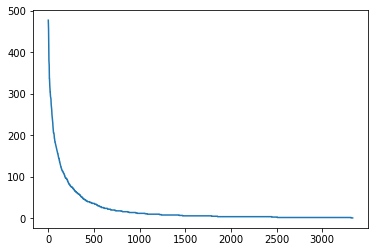

In [7]:
# extract degree of each airport sorted in decreasing order
degrees = [airport[1] for airport in sorted(nx.degree(G), key=lambda x: x[1], reverse=True)]

plt.plot(degrees)

# Mapping Individual Airports to Countries

In [8]:
# Read airport data to map Airport ID -> Country
df2 = pd.read_csv('airports.txt')

In [9]:
df2 = df2.drop(['Latitude','Longitude','Altitude','Timezone','DST',
                'database time zone','Type','Source','City','Name'], axis=1) 
display(df2)

,Airport ID,Country,IATA,ICAO
0,1,Papua New Guinea,GKA,AYGA
1,2,Papua New Guinea,MAG,AYMD
2,3,Papua New Guinea,HGU,AYMH
3,4,Papua New Guinea,LAE,AYNZ
4,5,Papua New Guinea,POM,AYPY
...,...,...,...,...
7693,14106,Russia,\N,ULDA
7694,14107,Russia,\N,XIUW
7695,14108,Russia,\N,ULLK
7696,14109,Chile,CPO,SCAT


In [10]:
# Get the country name from ID number
country = dict()

for index, row in df2.iterrows(): 
    country[row['Airport ID']] = row['Country']

# helper function to retrieve country name given an airport ID
def get_country(ID):
    # @return country_name - str
    
    if ID == "\\N" or float(ID) not in country:
        return 'No ID'
    
    return country[float(ID)]


# Ranking Countries By Number of Airports

In [11]:
num_airports = dict()

for airport in  nx.degree(G):
    name = get_country(airport[0])
    if name != 'No ID':
        num_airports[name] = num_airports.get(name, 0) + 1
    
names, num = [], [] 
for name, count in sorted(num_airports.items(), key=lambda item: item[1], reverse=True):
    names.append(name)
    num.append(count)

d = {'Country': names, 'Number of Airports': num}
country_df = pd.DataFrame(data=d)
country_df.head(25)

,Country,Number of Airports
0,United States,552
1,Canada,206
2,China,173
3,Brazil,122
4,Australia,113
5,Russia,103
6,India,70
7,Indonesia,63
8,Japan,62
9,Mexico,56


# International Flight Network 

In [12]:
# International graph network, weighted by number of routes between two countries
country_graph = nx.DiGraph()
for index, row in df.iterrows(): 
    source, destination = get_country(row['Source ID']), get_country(row['Destination ID'])
    
    if source != 'No ID' and destination != 'No ID':
        if country_graph.has_edge(source, destination):
            country_graph[source][destination]['weight'] += 1
        else:
            country_graph.add_edge(source, destination, weight=1) 

# Summary Statistics of International Travel Network 

In [13]:
print(nx.info(country_graph))

Name: 
Type: DiGraph
Number of nodes: 225
Number of edges: 4697
Average in degree:  20.8756
Average out degree:  20.8756


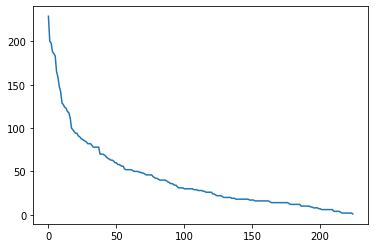

In [14]:
degrees = [airport[1] for airport in sorted(nx.degree(country_graph), key=lambda x: x[1], reverse=True)]
plt.plot(degrees)